In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import torch

## Regression example

In [2]:
def func(x):
    return x*(x-1)*(x+1)

In [3]:
rxs = np.random.uniform(-1,1,8)
rys = func(rxs)+np.random.normal(0,0.05,len(rxs))

That's how the data looks like:

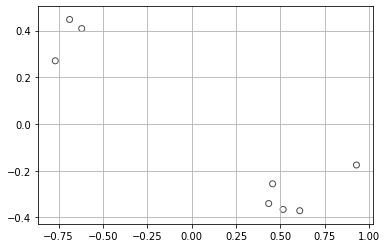

In [4]:
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black");
plt.grid()

To find the mapping corresponding to this data we will use the MSE loss. Untill now all was rather abstract, we were talking about optimizing over a space of all possible functions. That's obviously not possible. The way to proceed is to take a familly of functions parametrized with some set of parameters and optimize over the space of those parameters. 

## Model capacity, underfitting and overfitting

A popular familly of functions are the polynomials of a given degree, the parameters being the polynomial coefficients.  

We will be not fitting the polynomials ourself. Instead we will use a  function `polyfit` from numpy that performs the optimization with respect to MSE loss. Then we will use function `polyval` to calculate the predictons and error:

In [5]:
train_errors = []
polys  = []
for deg in range(8):
    p = np.polyfit(rxs,rys,deg)
    polys.append(p)
    pred_rys = np.polyval(p, rxs) 
    resid = pred_rys-rys
    err_train= 0.5*np.dot(resid, resid)/len(rxs)
    train_errors.append(np.array([deg, err_train]))
fit_res_train = np.stack(train_errors,axis=0)    

And here is how the MSE looks as a function of the polynomial degree:

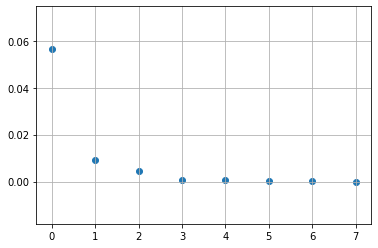

In [6]:
plt.grid()
plt.scatter(fit_res_train[:,0], fit_res_train[:,1]);

In [7]:
rxs_valid = np.random.uniform(-1,1,8)
rys_valid = func(rxs_valid)+np.random.normal(0,0.05, len(rxs_valid))

And check how the model performs on them

In [8]:
validation_errors =[]
for deg in range(8):
    p = polys[deg]
    pred_ys = np.polyval(p, rxs_valid) 
    resid = pred_ys-rys_valid
    err_valid= 0.5*np.dot(resid, resid)/len(rxs_valid)
    validation_errors.append(np.array([deg, err_valid]))
fit_res_valid = np.stack(validation_errors, axis=0)    

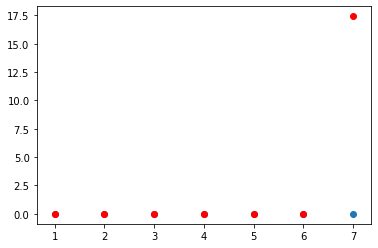

In [9]:
filter = ((fit_res_valid[:,0]>0) & (fit_res_valid[:,0]<25) )
plt.scatter(fit_res_train[filter,0], fit_res_train[filter,1])
plt.scatter(fit_res_valid[filter,0], fit_res_valid[filter,1], c='red');

We see that this *validation error* behaves at the begining similarly to training error. It's decreases with increasing degree. But at certain moment it start to increase in this case quite dramaticaly.

This unfortunately is also typical. Let's look what happens:

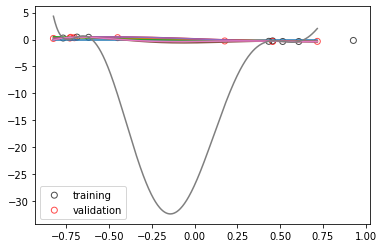

In [10]:
xs = np.linspace(rxs_valid.min(), rxs_valid.max(), 500)
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black", label="training");
plt.scatter(rxs_valid,rys_valid, alpha=0.7, color='none', edgecolor="red", label="validation");
for i in range(8):
    ys = np.polyval(polys[i],xs)
    plt.plot(xs,ys);
plt.legend();


In [11]:
poly = PolynomialFeatures(6)

In [12]:
poly.fit(rxs.reshape(-1,1))

PolynomialFeatures(degree=6, include_bias=True, interaction_only=False,
                   order='C')

In [13]:
poly_rxs = poly.fit_transform(rxs.reshape(-1,1))
t_rxs = torch.from_numpy(poly_rxs.astype('float32'))
t_rys = torch.from_numpy(rys.reshape(-1,1).astype('float32'))

In [14]:
poly_rxs_valid = poly.fit_transform(rxs_valid.reshape(-1,1))
t_rxs_valid = torch.from_numpy(poly_rxs_valid.astype('float32'))
t_rys_valid = torch.from_numpy(rys.reshape(-1,1).astype('float32'))

In [15]:
linear = torch.nn.Linear(in_features=t_rxs.shape[-1], out_features=1)
torch.nn.init.uniform_(linear.weight,-1.0, 1.0)

Parameter containing:
tensor([[-0.5427, -0.0873, -0.4303,  0.6429,  0.8897,  0.4286, -0.8535]],
       requires_grad=True)

In [16]:
optim = torch.optim.SGD(linear.parameters(), lr=0.001, weight_decay=0)

In [17]:
for e in range(10000):
    optim.zero_grad()
    pred = linear(t_rxs)
    loss = torch.nn.functional.mse_loss(pred, t_rys)
    loss.backward()
    optim.step()
print(loss)    

tensor(0.0027, grad_fn=<MseLossBackward>)


In [18]:
torch.nn.functional.mse_loss(linear(t_rxs_valid), t_rys_valid)

tensor(0.1192, grad_fn=<MseLossBackward>)

In [19]:
linear.weight

Parameter containing:
tensor([[-0.3604, -0.7667, -0.2765,  0.3815,  0.9763,  0.3222, -0.8097]],
       requires_grad=True)

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [21]:
reg = Ridge(fit_intercept=False, alpha=0.1)

In [22]:
fit = reg.fit(poly_rxs, rys.reshape(-1,1))

In [23]:
fit.coef_

array([[-0.05384843, -0.59601718,  0.07449571,  0.08317094,  0.07418871,
         0.24131306,  0.07560322]])